In [1]:
import os
import sys
from time import sleep
import math
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)

import torch
from torchvision.transforms import v2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
# import seaborn_image as isns
import tqdm.notebook as tqdm
import gc

sys.path.append('../dataset_construction')
from pano_utils import *
from panoseti_file_interfaces import ObservingRunInterface

%load_ext autoreload


from cnn_model import *
from data_loaders import *
from training_utils import *
%autoreload 2

<Figure size 1500x1000 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset CloudDetectionInference
    Number of datapoints: 613
    StandardTransform
Transform: Compose(
                 ToTensor()
                 ToDtype(scale=True)
           )


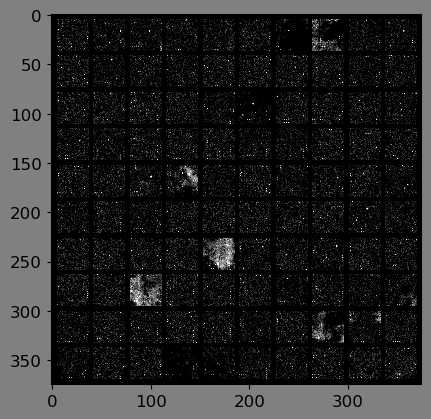

In [341]:
batch_size = 64
batch_id = 1
img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-iifft'

transform = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float, scale=True)
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inference_data = CloudDetectionInference(
    batch_id = batch_id,
    transform = transform
)
inference_loader = torch.utils.data.DataLoader(
  dataset=inference_data,
  batch_size=batch_size
)
images = [inference_data[i][img_type]*10 for i in np.random.choice(len(inference_data), size=min(100, len(inference_data)), replace=False)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)))
print(inference_data)

In [342]:
model = CloudDetection()
# model.load_state_dict(torch.load('../model_training/best_cloud_detection_model_2-24-24.pth'))
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model_2-24-24_2.pth'))
device = get_device()
model.to(device)
with open('../model_training/model_summary.txt', 'r') as f:
    # print(f.read())
    ...

In [343]:
# test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=False)
# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = np.array([], dtype=int)
with torch.no_grad():
    model.eval() # Put model in eval mode
    for img_data in tqdm.tqdm(inference_loader, unit="batch"):
        x = img_data[img_type]
        x = x.float().to(device)
        pred = model(x)
        # predictions = torch.cat((predictions, torch.argmax(pred, dim=1)))
        predictions = np.concatenate((predictions, torch.argmax(pred, dim=1).to('cpu').numpy()))
inference_data.inference_session.add_labels(predictions)
inference_data.inference_session.save_progress()
print(predictions)

  0%|          | 0/10 [00:00<?, ?batch/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [344]:
get_path = inference_data.inference_session.get_pano_feature_fpath
labeled = inference_data.inference_session.labeled_df

cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
clear = labeled[labeled['label'] == 'clear_night_sky']
print(f'ncloudy = {len(cloudy)}, nclear = {len(clear)}')

ncloudy = 95, nclear = 518


In [345]:
gc.collect()

80151

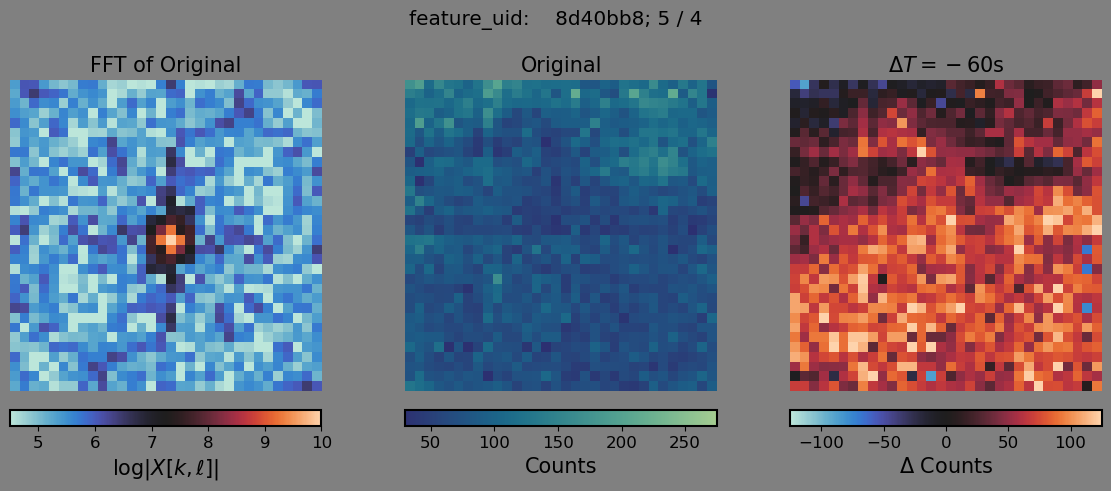

Done


In [354]:
plt.rcParams["figure.facecolor"] = 'grey'
plt.rcParams["font.size"] = 12
def do_movie(label, dtype_idx, step):
    assert 0 <= dtype_idx < 3 and isinstance(dtype_idx, int)
    img_types = {
        0: 'raw-original',
        1: 'raw-derivative.-60',
        2: 'raw-fft'
    }
    img_type = img_types[dtype_idx]
    with_label = labeled.loc[labeled['label'] == label]
    try:
        for i, fuid in enumerate(with_label['feature_uid'][::step]):
            data = np.load(get_path(fuid, img_type))
            
            fig, axs = plt.subplots(1, 3, figsize=(11, 4.8), constrained_layout=True)
            fig.suptitle(f'feature_uid: {fuid[:7]:>10}; {i + 1} / {len(with_label) // step}')

            # FFT of original stacked original
            im2 = axs[0].imshow(
                np.load(get_path(fuid, 'raw-fft')), vmin=4.5, vmax=10, cmap='icefire'
            )
            axs[0].axis('off')
            axs[0].set_title('FFT of Original')

            # Original stacked pano image
            im0 = axs[1].imshow(
                np.load(get_path(fuid, 'raw-original')), vmin=30, vmax=275, cmap='crest_r'
            )
            axs[1].axis('off')
            axs[1].set_title('Original')

            # -60 second time derivative
            im1 = axs[2].imshow(
                np.load(get_path(fuid, 'raw-derivative.-60')), vmin=-125, vmax=125, cmap='icefire'
            )
            axs[2].axis('off')
            axs[2].set_title(f'$\Delta T = -60$s')


            

            
            # if img_type == 'raw-original':
            #     # ObservingRunInterface.plot_image(
            #     #     data, bins=50, vmin=30, vmax=275, cmap='crest_r'#, perc=(45, 55)
            #     # )
            #     im0 = axs[0].imshow(
            #         data, vmin=30, vmax=275, cmap='crest_r'
            #     )
            
            # elif img_type == 'raw-derivative.-60':
            #     # ObservingRunInterface.plot_image(
            #     #     data, bins=40, vmin=-150, vmax=150, cmap='icefire', perc=(0.5, 99.5)
            #     # )
            #     im1 = axs[1].imshow(
            #         data, vmin=-125, vmax=125, cmap='icefire'
            #     )

            
            # elif img_type == 'raw-fft':
            #     # ObservingRunInterface.plot_image(
            #     #     data, bins=50, vmin=4.5, vmax=10, cmap='icefire'#, perc=(45, 55)
            #     # )
            #     im2 = axs[2].imshow(
            #         data, vmin=4.5, vmax=10, cmap='icefire'
            #     )
            cbar0 = fig.colorbar(im0, label='Counts', fraction=0.046, location='bottom')
            cbar1 = fig.colorbar(im1, label = r'$\Delta$ Counts', fraction=0.046, location='bottom')
            cbar2 = fig.colorbar(im2, label='$\log|X[k, \ell]|$', fraction=0.046, location='bottom')
            

            display.clear_output(wait=True)
            plt.show()
            # i = input()
            plt.close(fig)
            sleep(0.02)
        print('Done')
    except KeyboardInterrupt:
        plt.close()
        print('Exiting...')
        return
        
        
    
do_movie('not_clear_cloudy', dtype_idx=2, step=20)
# do_movie('clear_night_sky', dtype_idx=2, step=20)

In [143]:
def make_img_grid(label, cols=8, rows_per_plot=6):
    """Grid of all classified images labeled as the given label"""
    with_label = labeled.loc[labeled['label'] == label]
    imgs = []

    for fuid in with_label['feature_uid']:
        data = np.load(get_path(fuid, img_type), allow_pickle=False)
        imgs.append(data)
    if len(imgs) == 0:
        print(f'No images labeled as "{label}"')
        return
    else:
        print(f'Images you classified as "{label}":')
    # Limit num rows in plot to ensure consistently-sized figures
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                feature_uid = with_label['feature_uid'].iloc[img_idx]
                ax.set_title(f'{23}{feature_uid[:6]}')  # Label each plot with first 6 chars of feature_uid
                ax.imshow(img, vmin=-150, vmax=150, cmap='icefire')
        plt.show()
        plt.close()


Images you classified as "clear_night_sky":


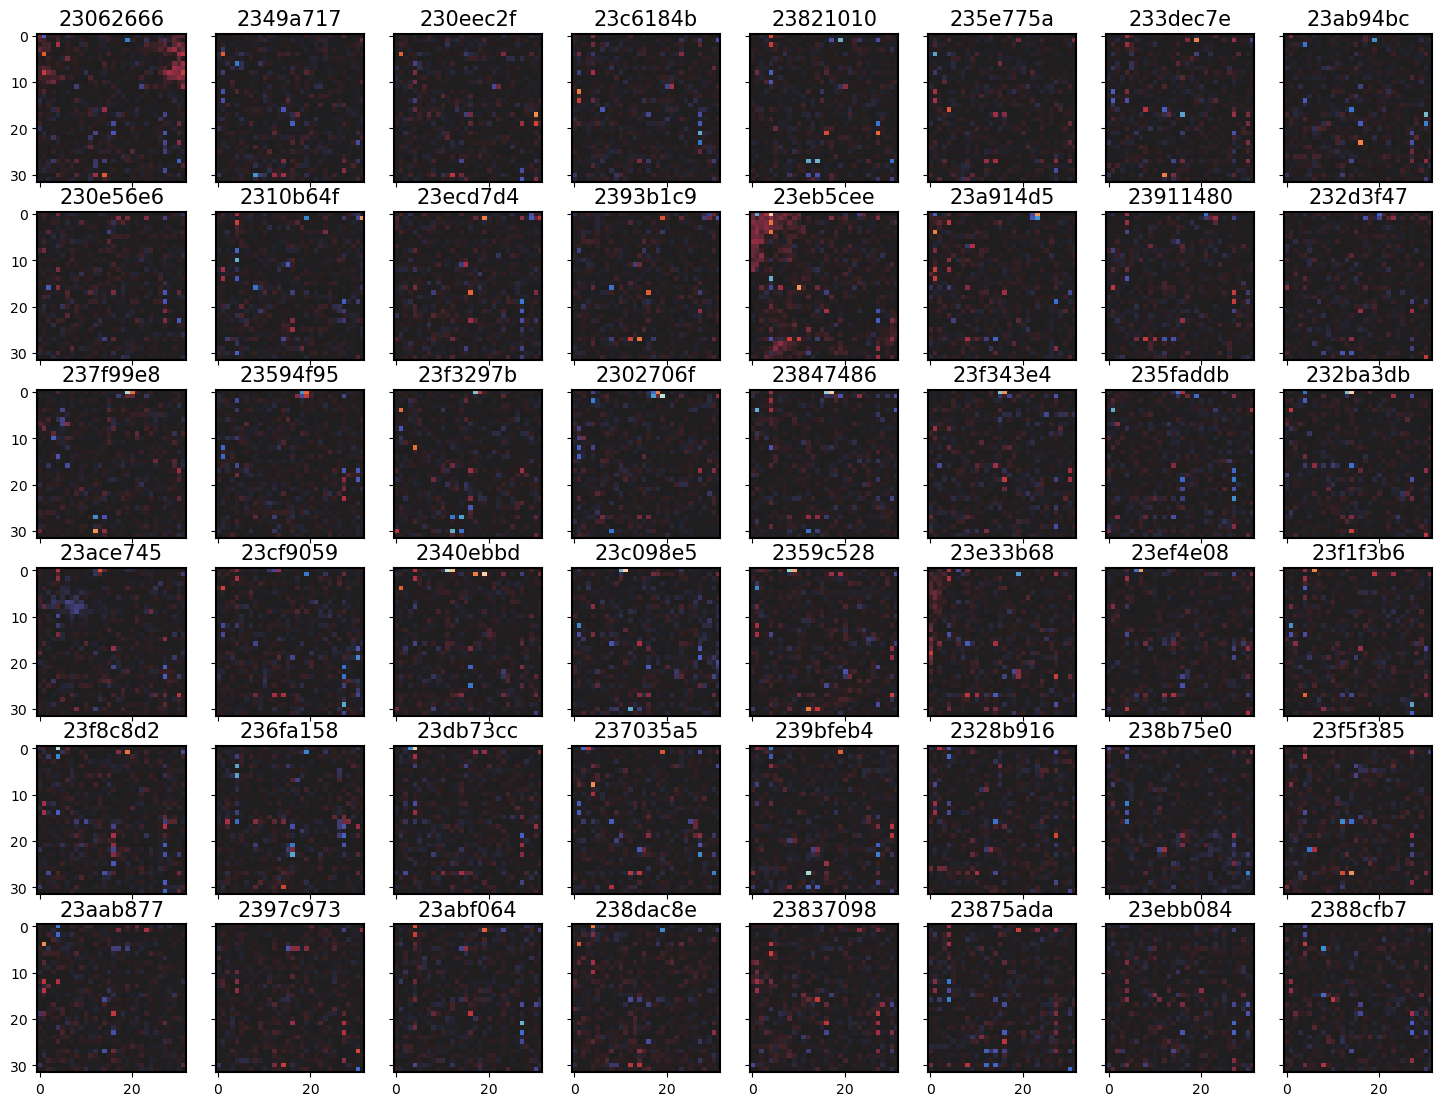

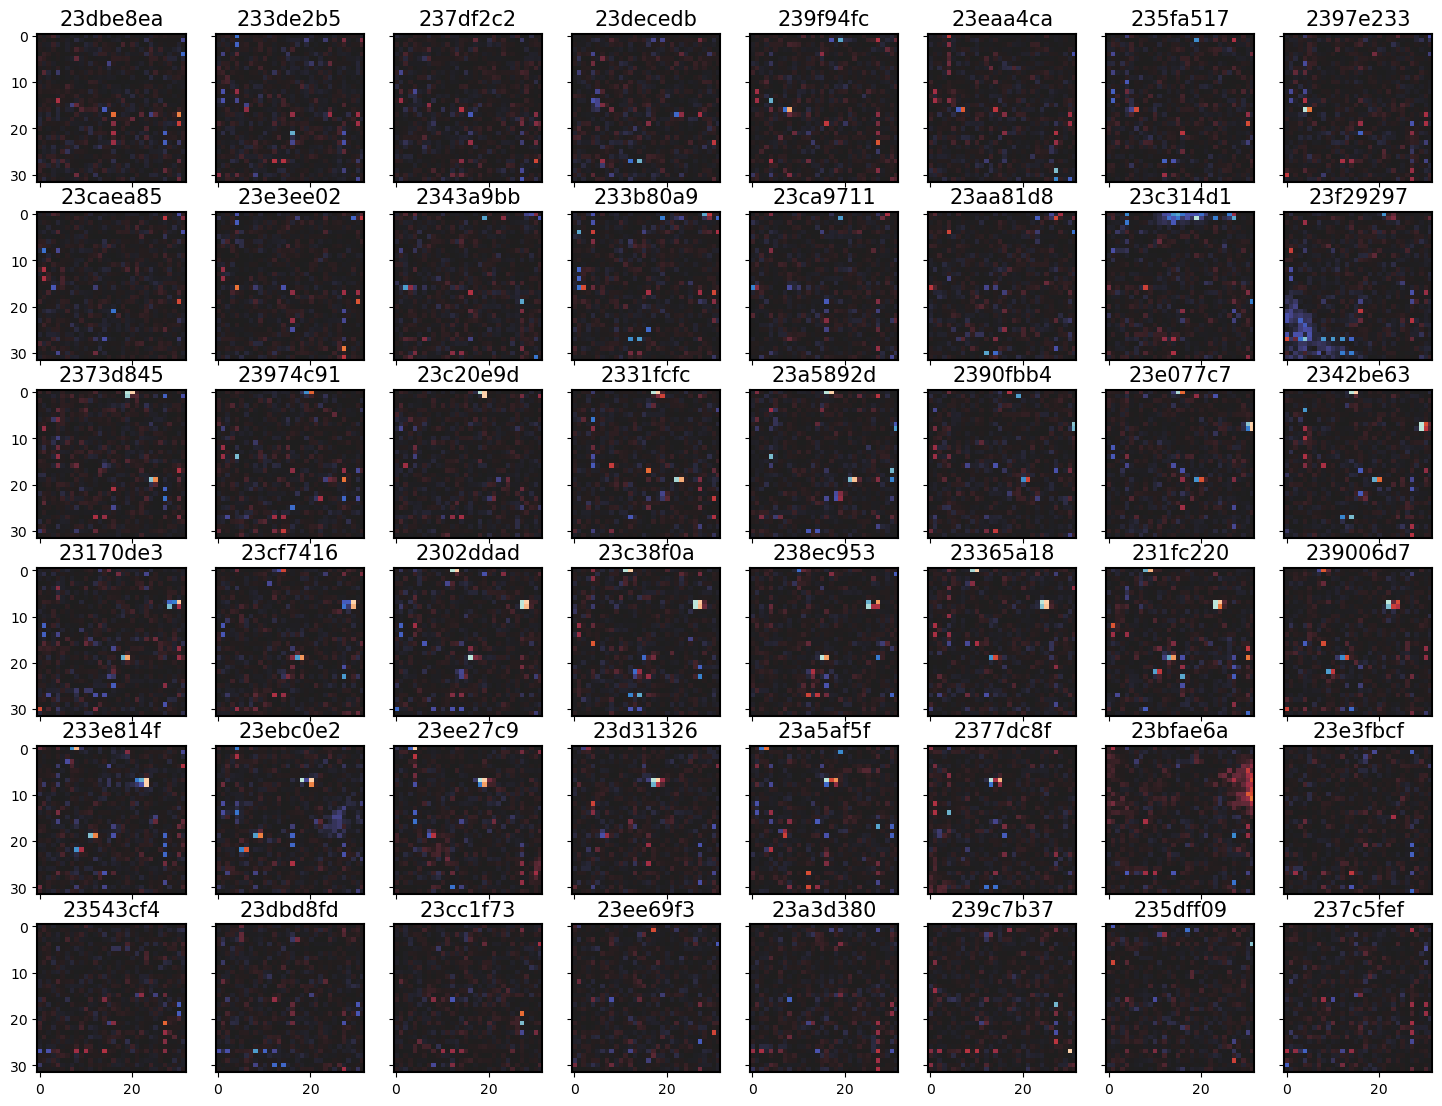

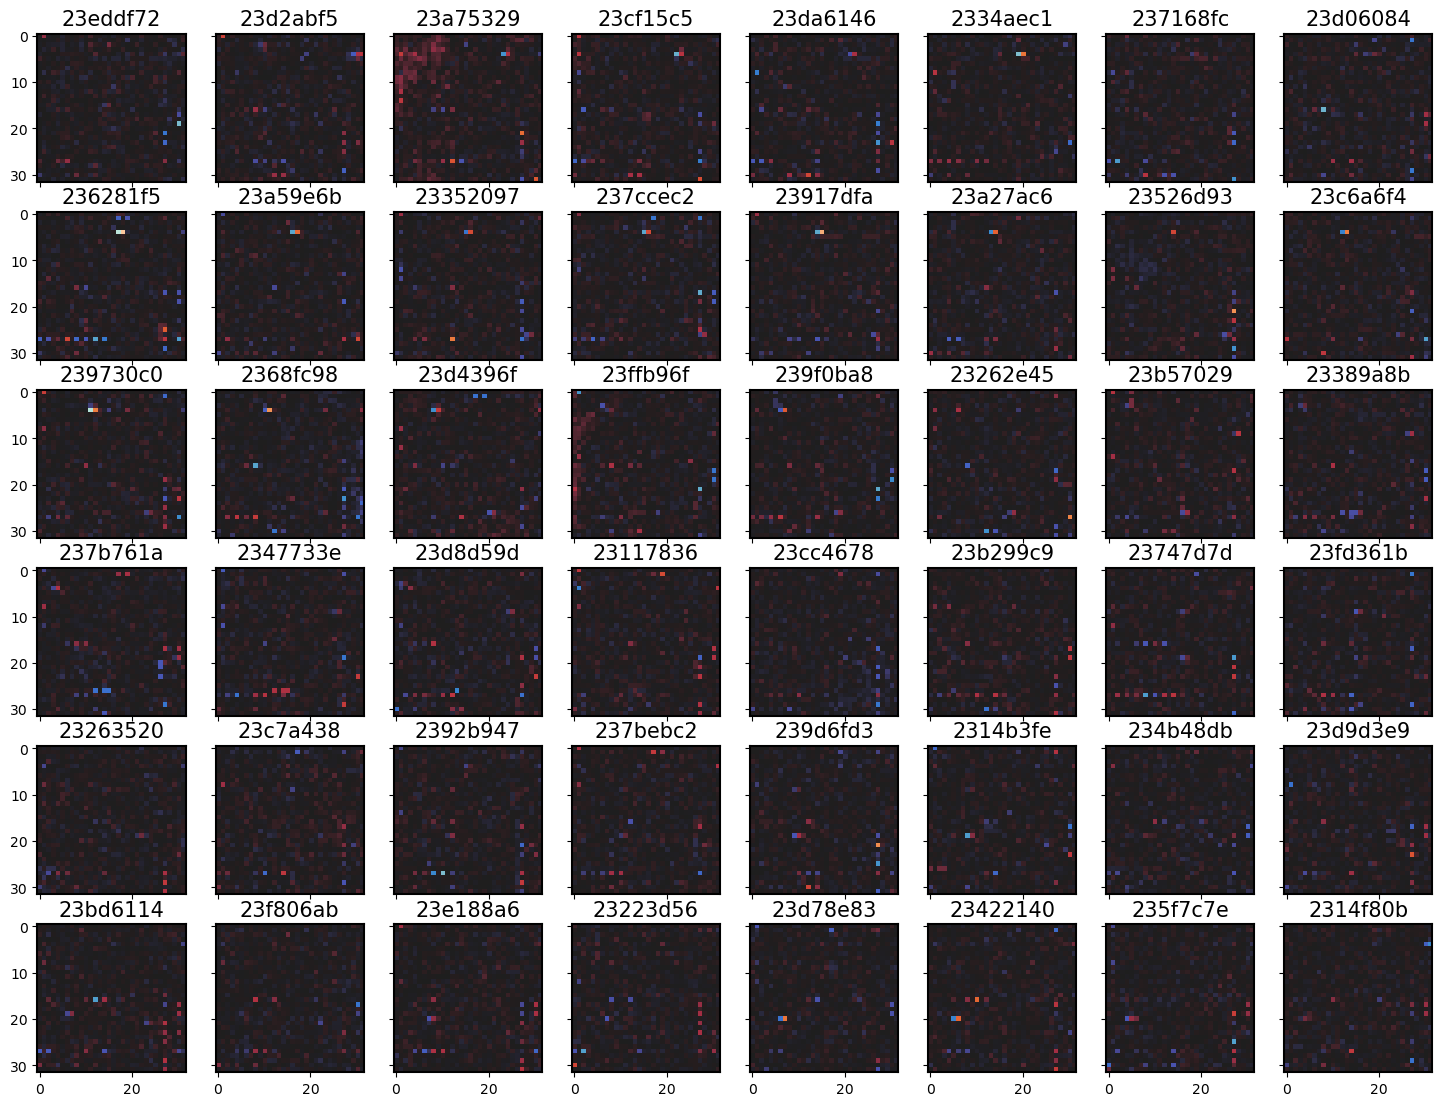

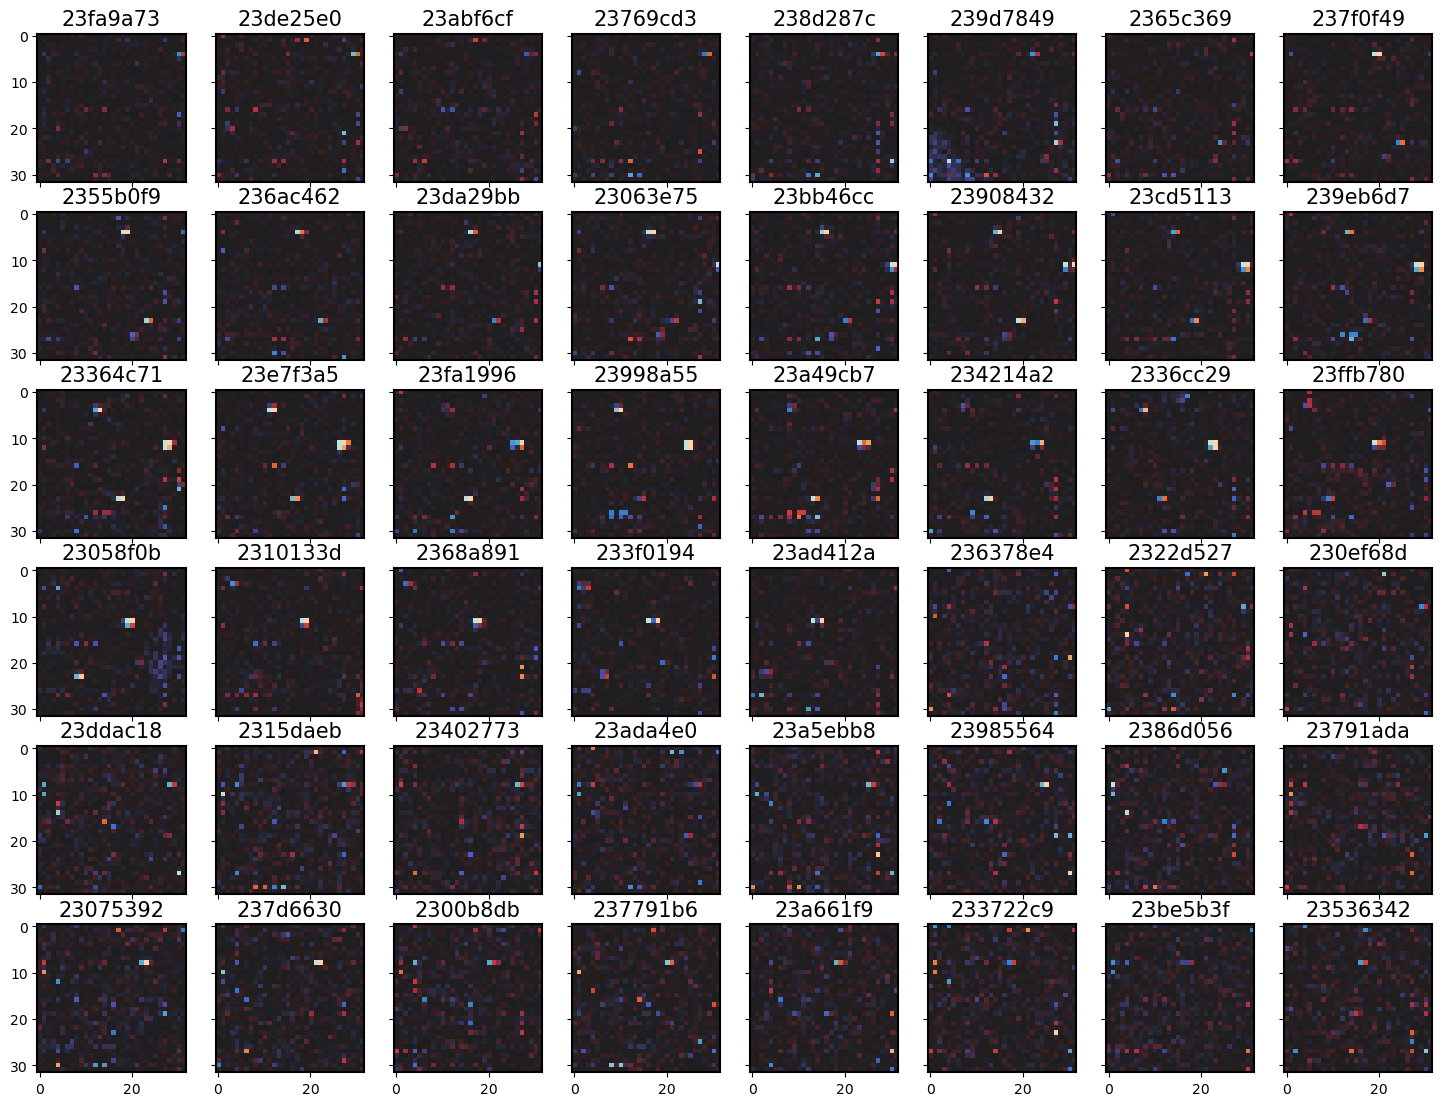

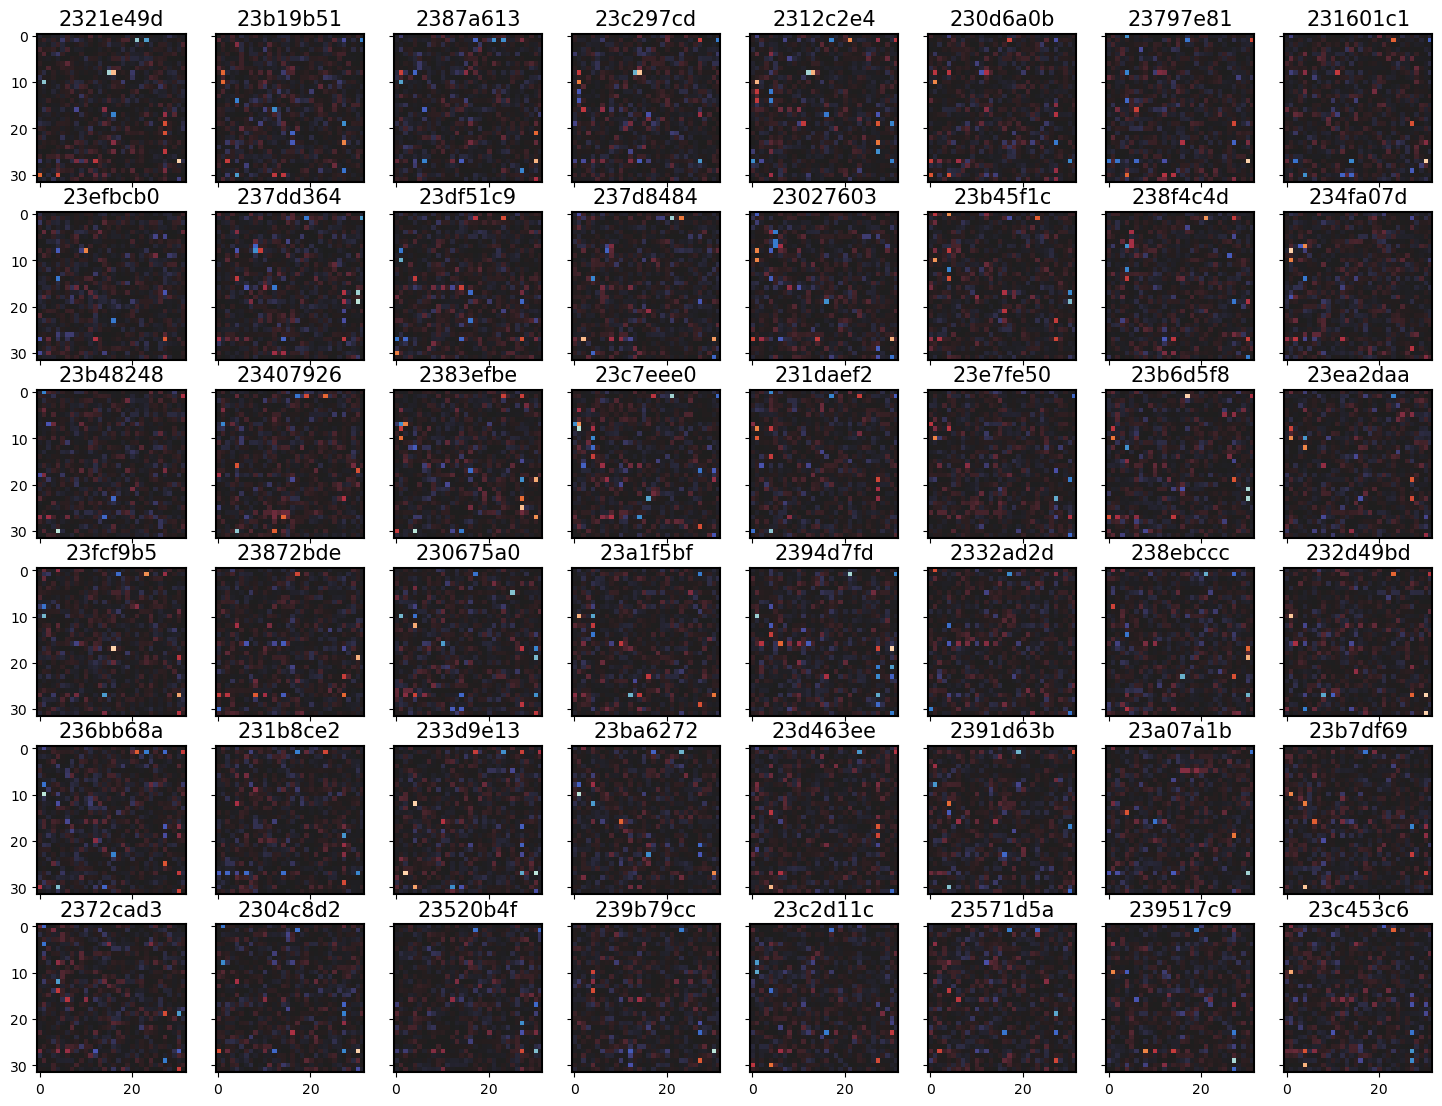

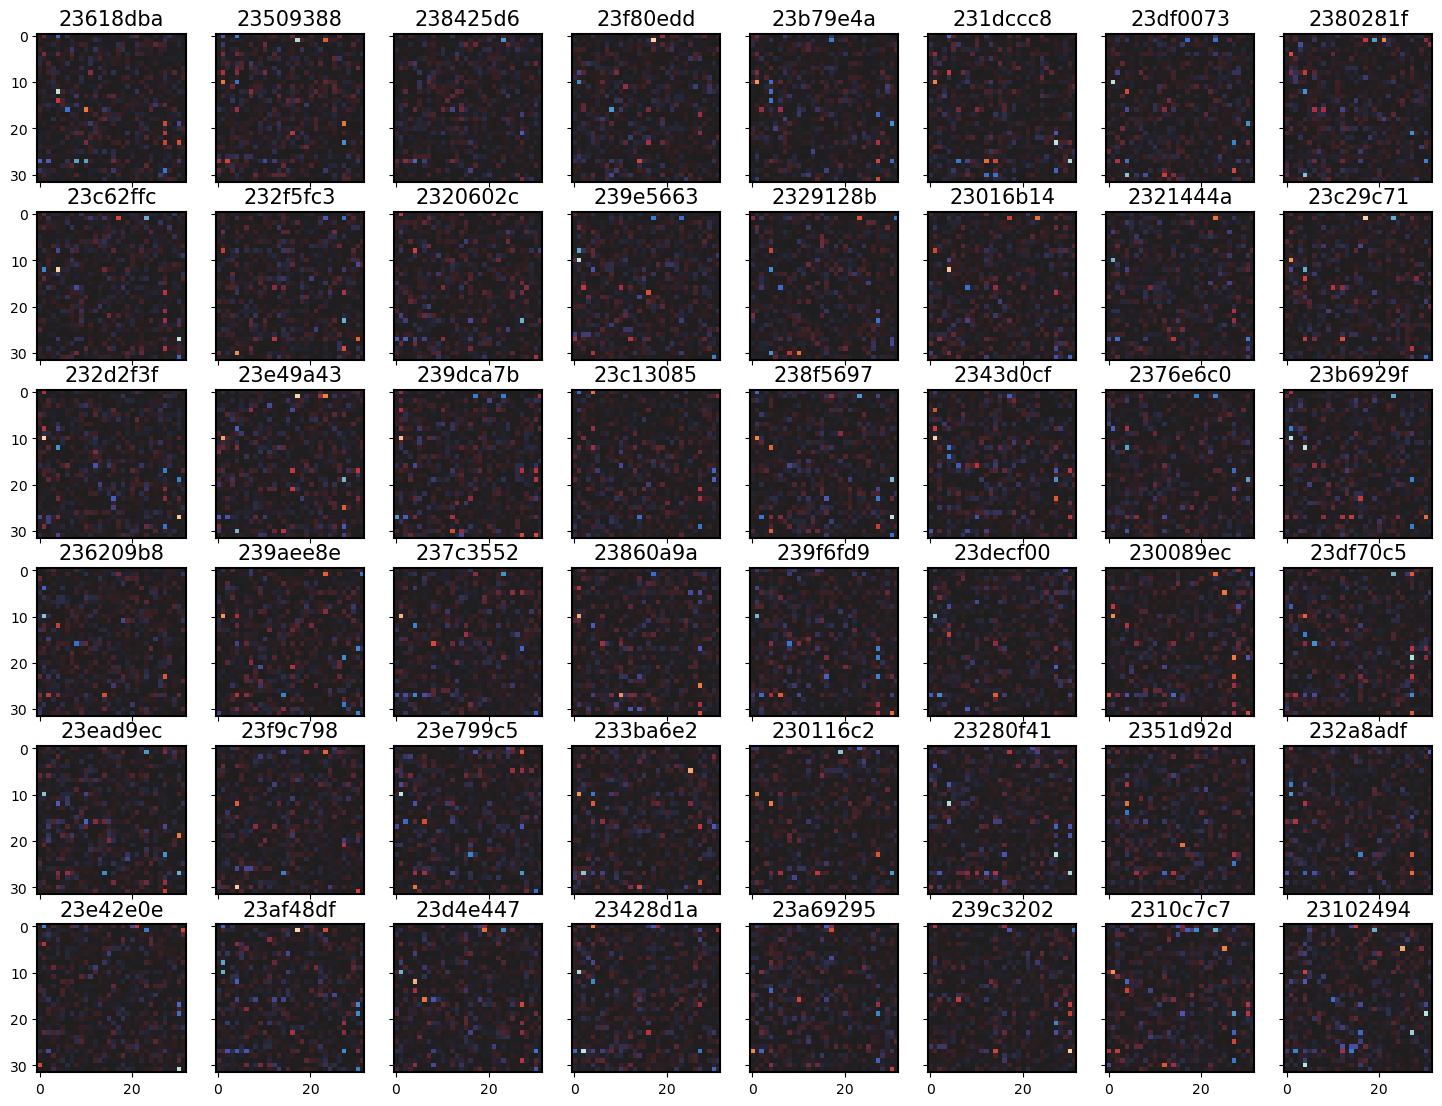

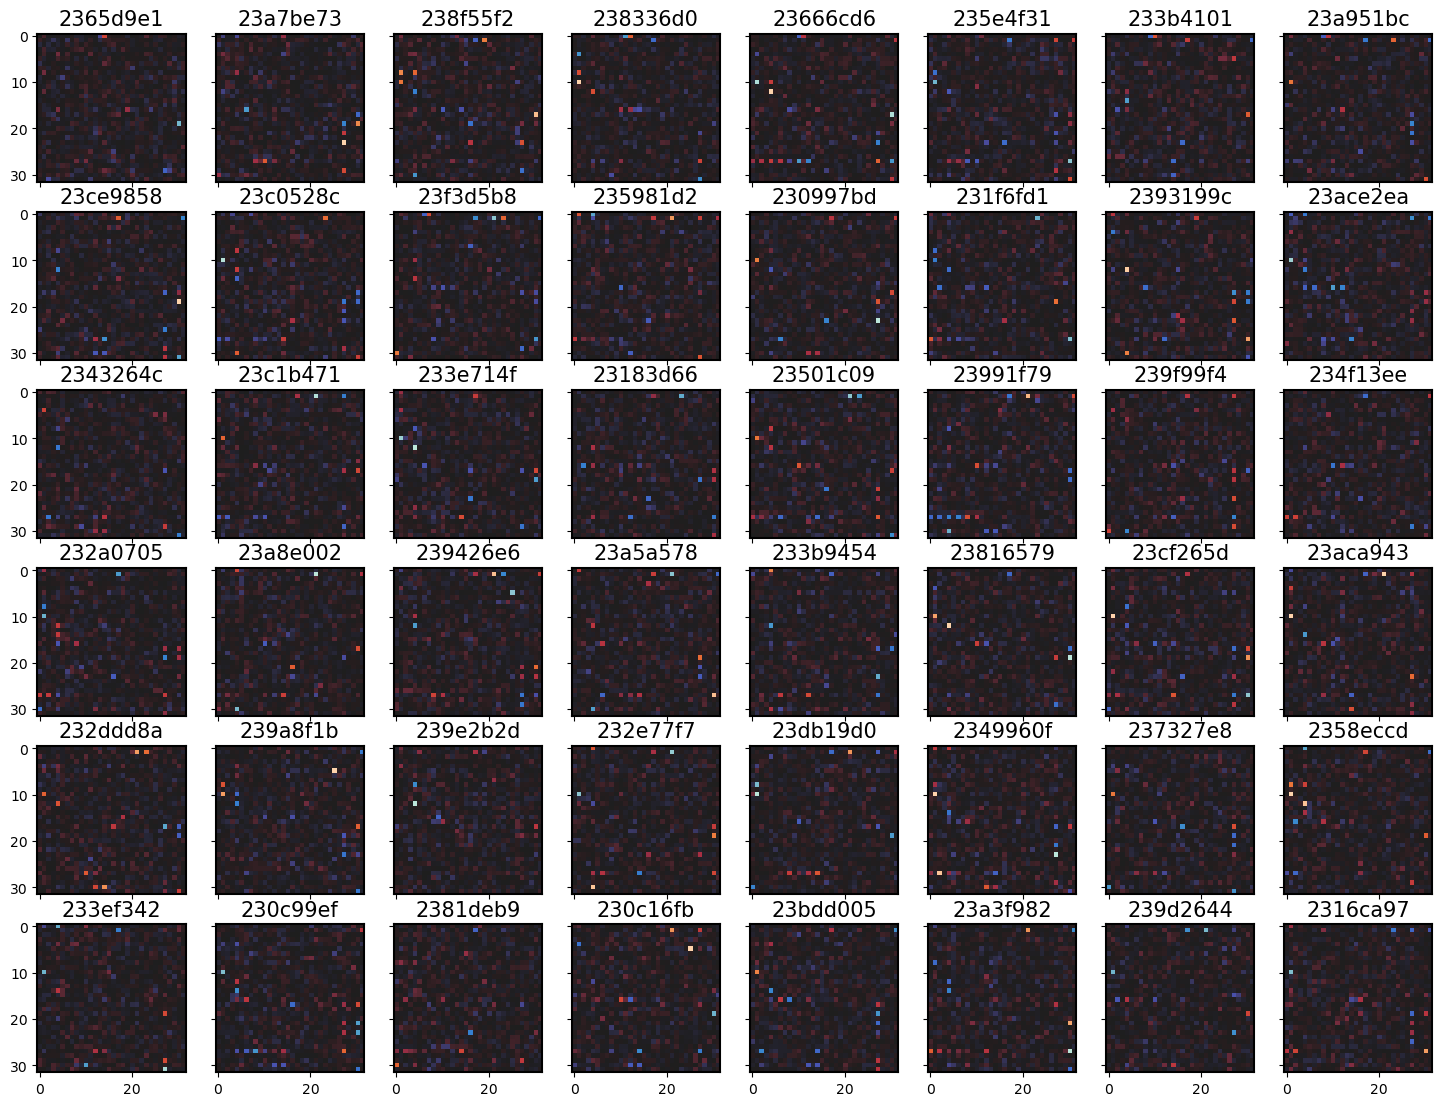

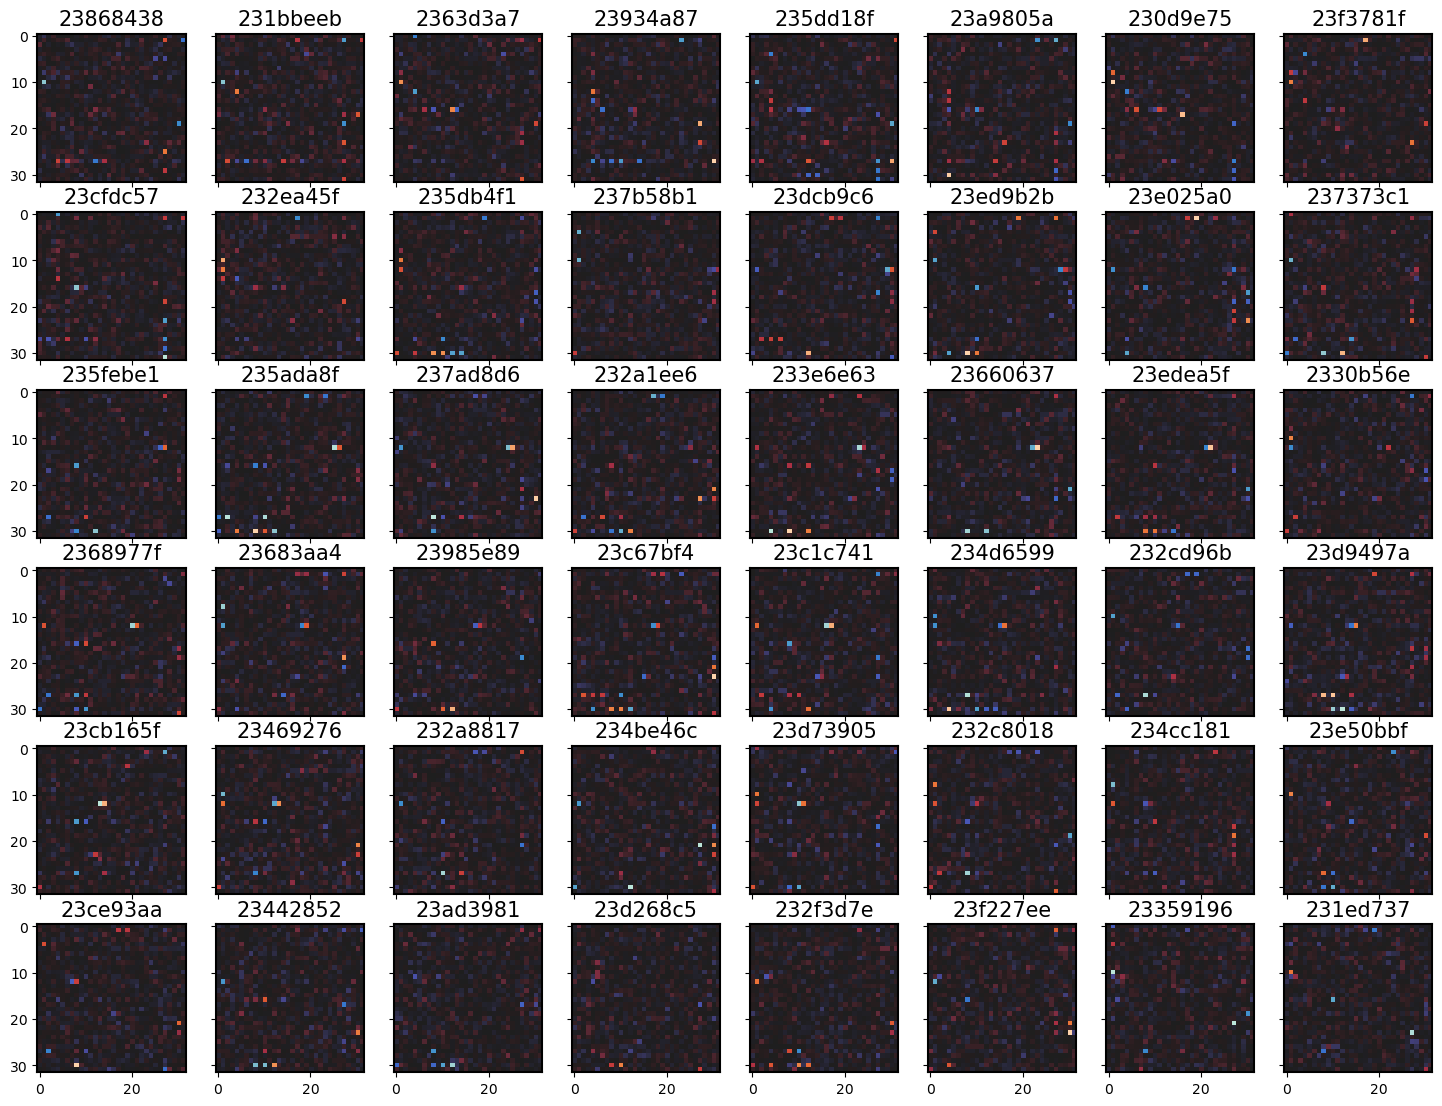

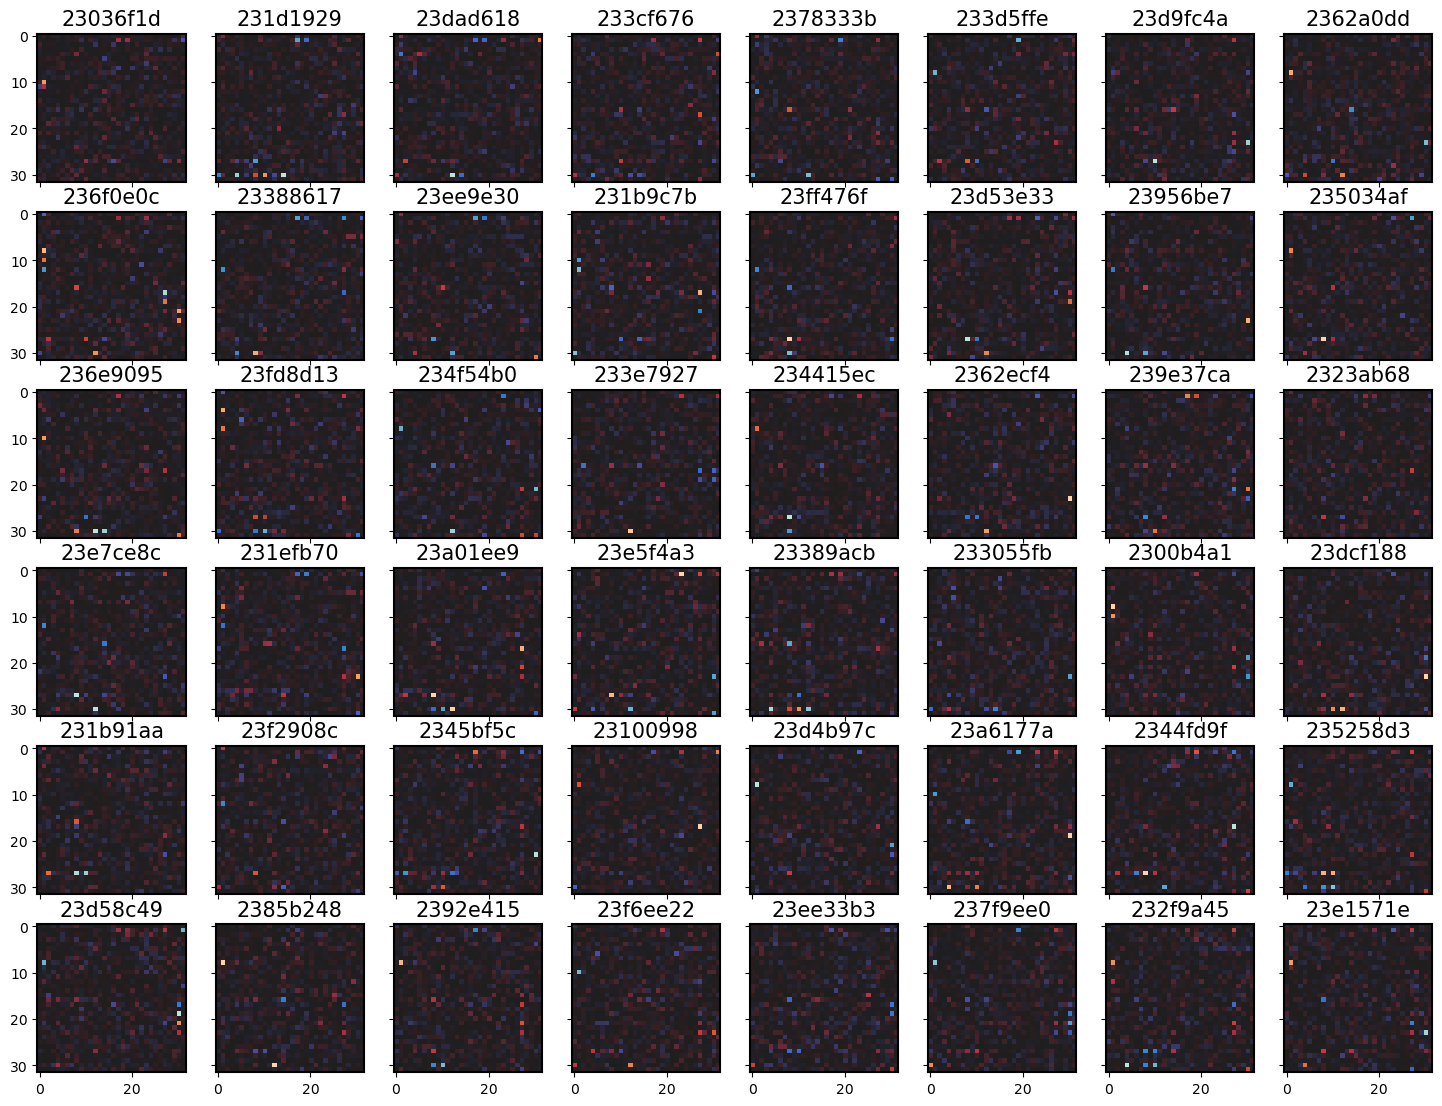

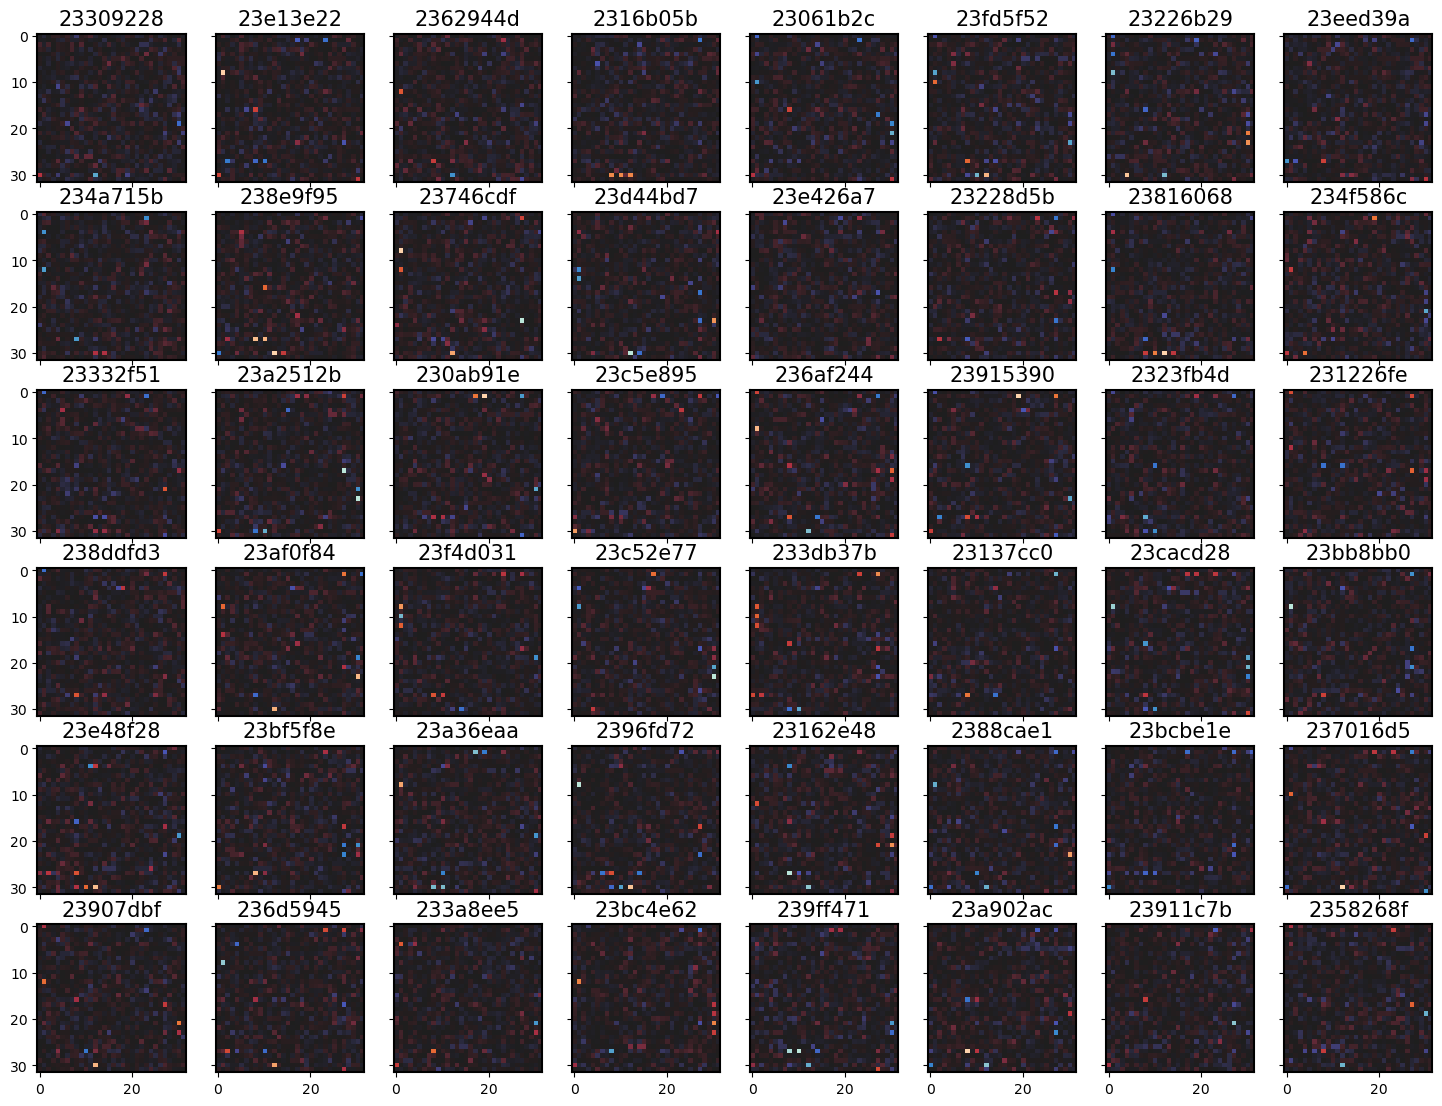

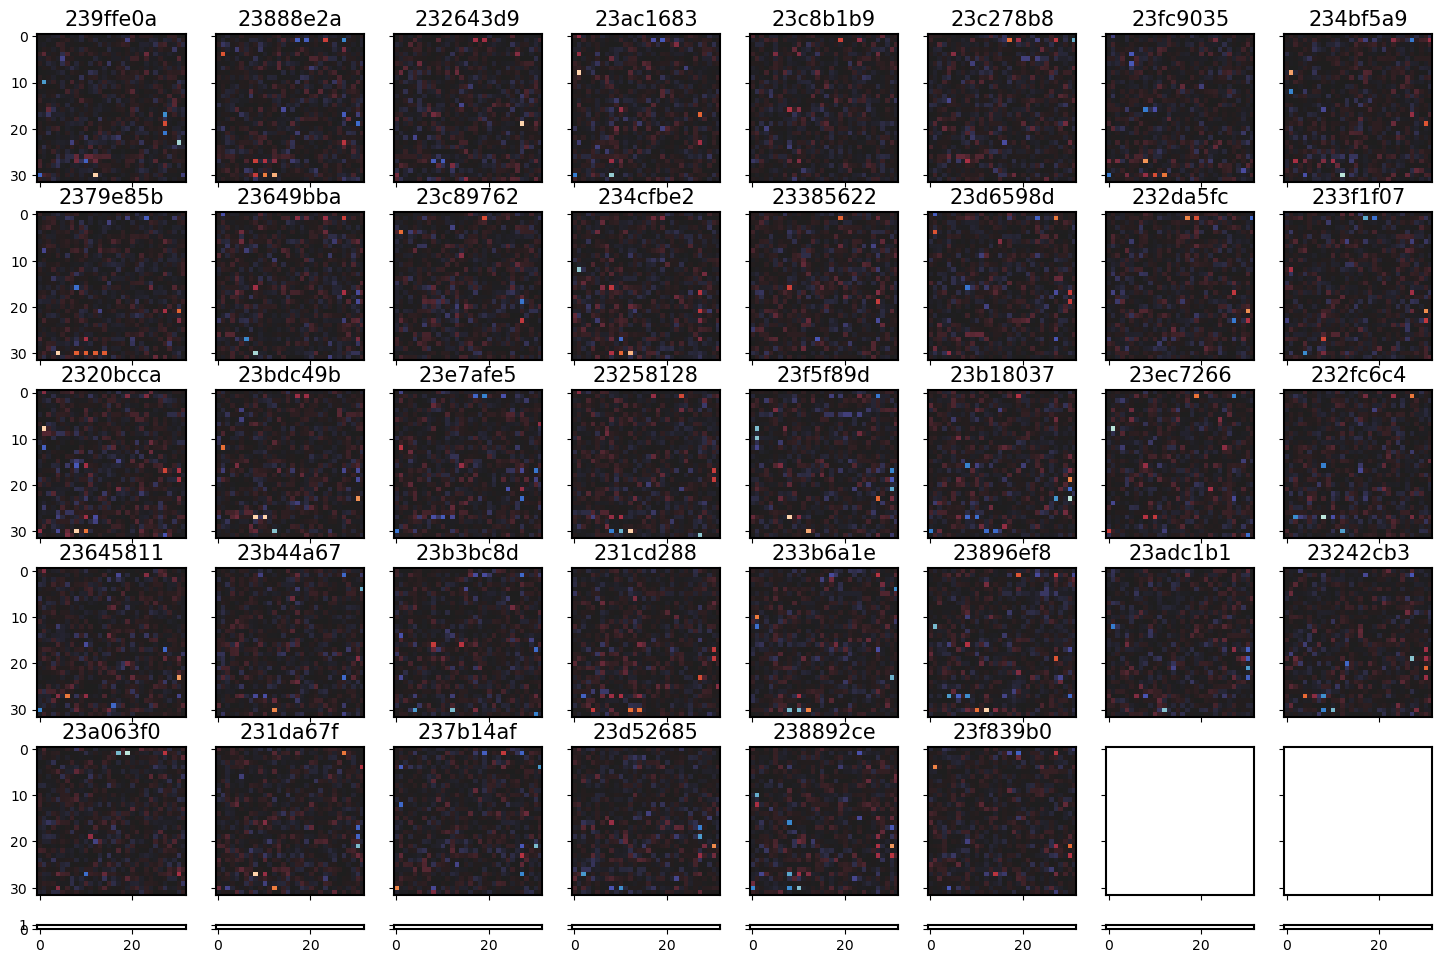

Images you classified as "not_clear_cloudy":


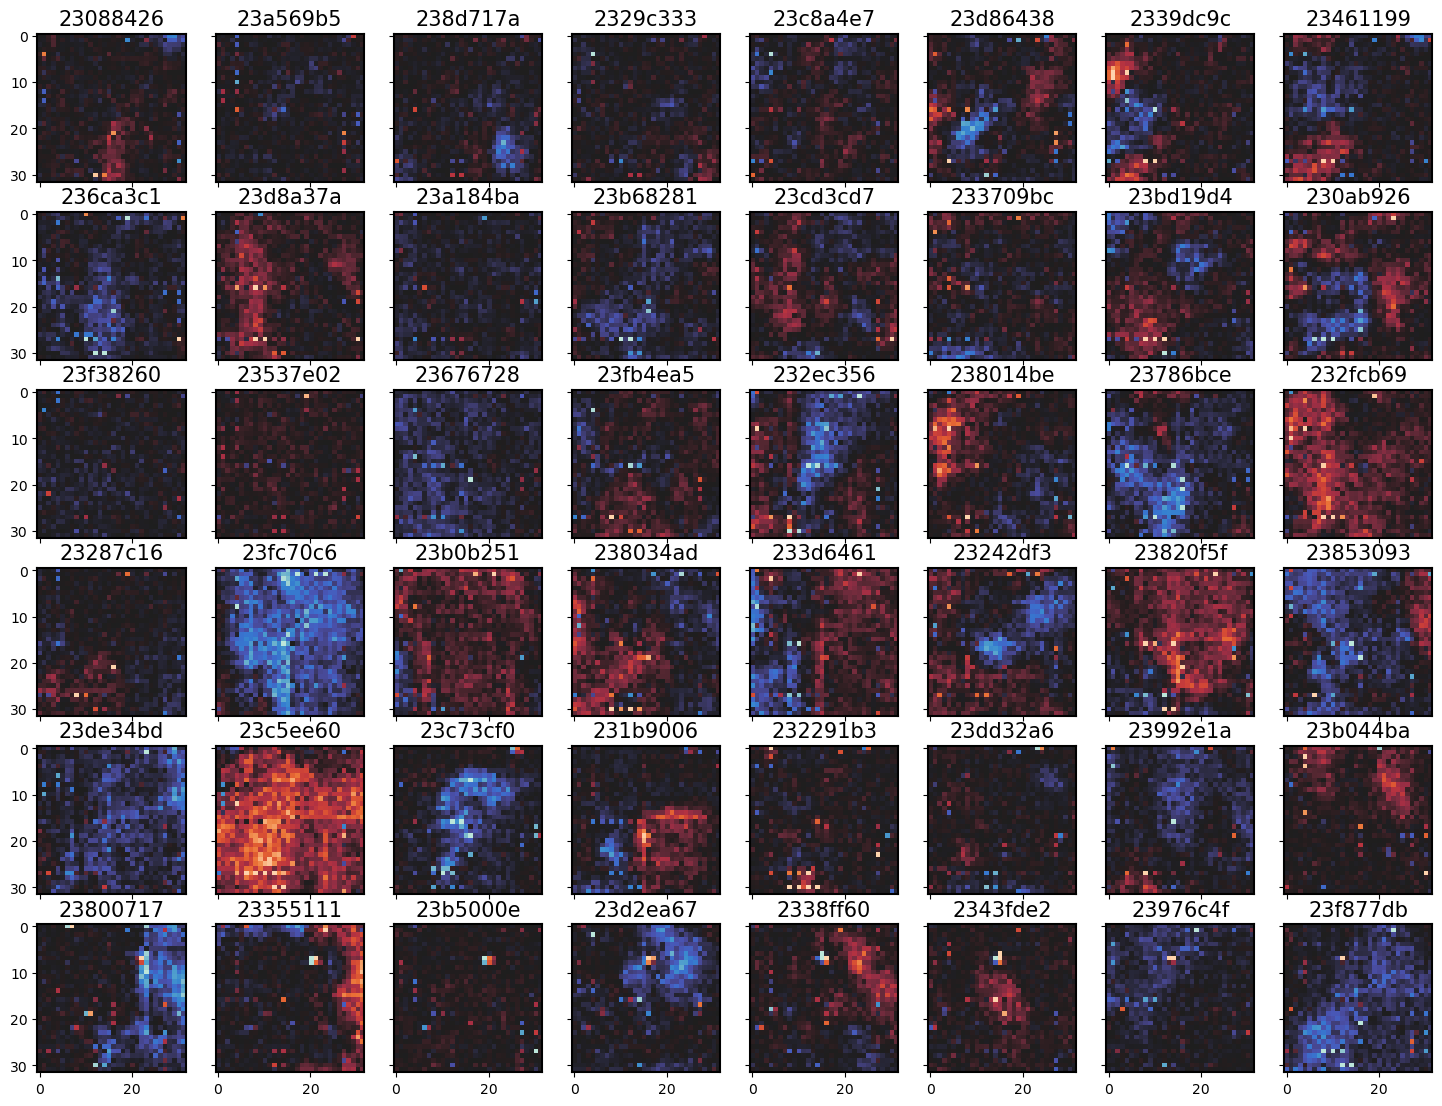

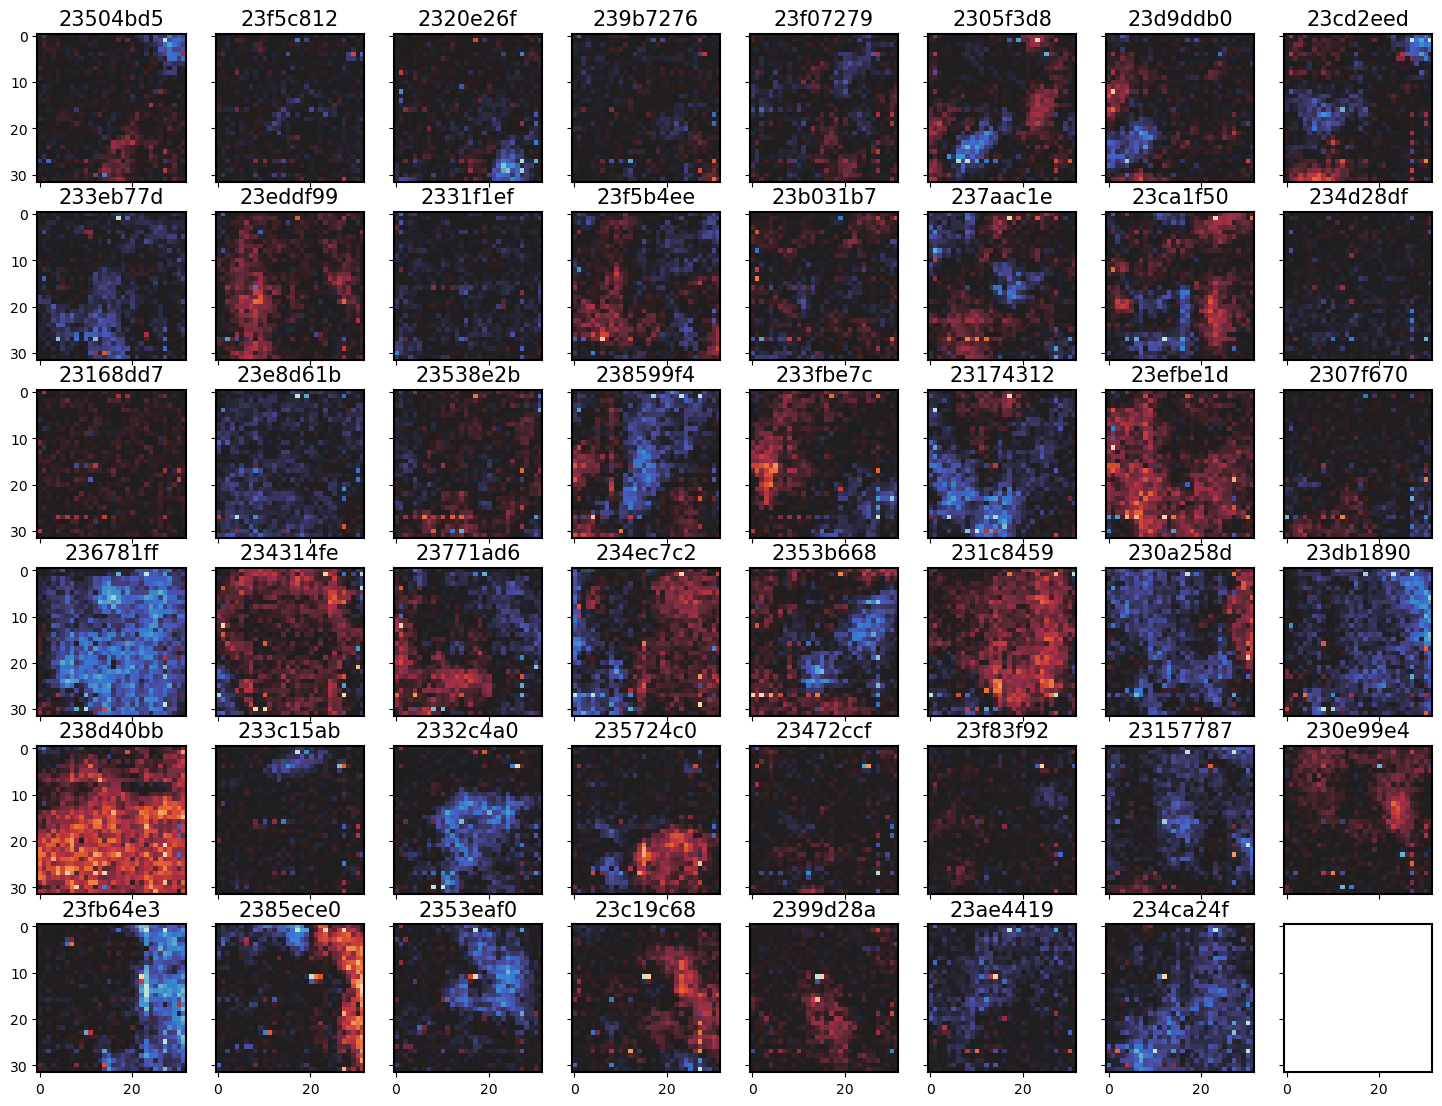

In [28]:
make_img_grid('clear_night_sky')
make_img_grid('not_clear_cloudy')